# Laboratorium 3: Analiza wrażliwości

**Imię i nazwisko:** Anna Bernard, Mikołaj Mieszko Charchuta 
**Grupa:**  Symulanci
**Data wykonania:**  29.05.2025

---

## 1. Wstęp

W tym laboratorium podjęliśmy się prób oceny wrażliwości lokalnej (opartej o funkcje wrażliwości) 
i globalnej (opartej o wskaźniki Sobola).

## 2. Opis zaimplementowanego rozwiązania

- **Wariant implementacji:** RK4 ze stałym krokiem, ręcznie wpisane pochodne
- **Biblioteki użyte:** numpy, matplotlib, SALib
- **Model:** Wrażliwość symulacji dynamiki białek p53, MDMcyto, MDMn, PTEN na zmiany parametrów reakcji w dwóch scenariuszach biologicznych
- **Horyzont czasowy:** 48 godzin (2880 minut)
- **Krok całkowania:** 6 minut
- **Wprowadzanie danych:** Przyjęcie domyślnych

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f_p53(params, p53, mdmn): 
    return params['p1'] - params['d1'] * p53 * (mdmn**2)

def f_mdmcyto(params, p53, mdmcyto, pten, siRNA=False, no_DNA_damage=False):
    siRNA_factor = value_siRNA if siRNA else 1
    DNA_damage_factor = value_no_DNA_damage if no_DNA_damage else 1
    return (params['p2'] * siRNA_factor * (p53**4) / ((p53**4) + (params['k2']**4))
            - params['k1'] * (params['k3']**2) / ((params['k3']**2) + (pten**2)) * mdmcyto
            - params['d2'] * DNA_damage_factor * mdmcyto)

def f_mdmn(params, mdmn, mdmcyto, pten, no_DNA_damage=False):
    if no_DNA_damage:
        return (params['k1'] * (params['k3']**2) / ((params['k3']**2) + (pten**2)) * mdmcyto
                - params['d2'] * value_no_DNA_damage * mdmn)
    else:
        return (params['k1'] * (params['k3']**2) / ((params['k3']**2) + (pten**2)) * mdmcyto
                - params['d2'] * mdmn)

def f_pten(params, pten, p53, pten_off=False):
    if not pten_off:
        return (params['p3'] * (p53**4) / ((p53**4) + (params['k2']**4))
                - params['d3'] * pten)
    else:
        return - params['d3'] * pten
        # return (params['p3'] * value_PTEN_off * (p53**4) / ((p53**4) + (params['k2']**4))
        #         - params['d3'] * pten)

    
# Pochodne tych funkcji(?):

# RK4 ze stałym krokiem
def RK4const(params, p53, mdcyto, mdmn, pten, h, siRNA=False, pten_off=False, no_DNA_damage=False):
    k1_p53 = f_p53(params, p53, mdmn)
    k1_mdmcyto = f_mdmcyto(params, p53, mdcyto, pten, siRNA)
    k1_mdmn = f_mdmn(params, mdmn, mdcyto, pten)
    k1_pten = f_pten(params, pten, p53, pten_off)

    k2_p53 = f_p53(params, p53 + h/2*k1_p53, mdmn + h/2*k1_mdmn)
    k2_mdmcyto = f_mdmcyto(params, p53 + h/2*k1_p53, mdcyto + h/2*k1_mdmcyto, pten + h/2*k1_pten, siRNA)
    k2_mdmn = f_mdmn(params, mdmn + h/2*k1_mdmn, mdcyto + h/2*k1_mdmcyto, pten + h/2*k1_pten)
    k2_pten = f_pten(params, pten + h/2*k1_pten, p53 + h/2*k1_p53, pten_off)

    k3_p53 = f_p53(params, p53 + h/2*k2_p53, mdmn + h/2*k2_mdmn)
    k3_mdmcyto = f_mdmcyto(params, p53 + h/2*k2_p53, mdcyto + h/2*k2_mdmcyto, pten + h/2*k2_pten, siRNA)
    k3_mdmn = f_mdmn(params, mdmn + h/2*k2_mdmn, mdcyto + h/2*k2_mdmcyto, pten + h/2*k2_pten)
    k3_pten = f_pten(params, pten + h/2*k2_pten, p53 + h/2*k2_p53, pten_off)

    k4_p53 = f_p53(params, p53 + h*k3_p53, mdmn + h*k3_mdmn)
    k4_mdmcyto = f_mdmcyto(params, p53 + h*k3_p53, mdcyto + h*k3_mdmcyto, pten + h*k3_pten, siRNA)
    k4_mdmn = f_mdmn(params, mdmn + h*k3_mdmn, mdcyto + h*k3_mdmcyto, pten + h*k3_pten)
    k4_pten = f_pten(params, pten + h*k3_pten, p53 + h*k3_p53, pten_off)


    p53 += (k1_p53 + 2*k2_p53 + 2*k3_p53 + k4_p53) * h / 6
    mdcyto += (k1_mdmcyto + 2*k2_mdmcyto + 2*k3_mdmcyto + k4_mdmcyto) * h / 6
    mdmn += (k1_mdmn + 2*k2_mdmn + 2*k3_mdmn + k4_mdmn) * h / 6
    pten += (k1_pten + 2*k2_pten + 2*k3_pten + k4_pten) * h / 6
    return p53, mdcyto, mdmn, pten

## 3. Parametry symulacji i scenariusze

In [9]:
# Warunki początkowe zgodnie z ustabilizowaną po 4800h liczbą cząsteczek w zdrowym hepatocycie:
p53_0 = 26854
mdmcyto_0 = 11173
mdmn_0 = 17245
pten_0 = 154378
proteins = [p53_0, mdmcyto_0, mdmn_0, pten_0] 

h = 6 # krok czasowy w minutach
iterations = int(48*60/h) # liczba iteracji na 48h
conditions = { 
        "Basic" : (False, False, True), # siRNA, PTEN_off, no_DNA_damage
        "Tumor" : (False, True, False),
}
scenarios = list(conditions.keys())

params = {
    'p1': 8.8,
    'p2': 440,
    'p3': 100,
    'd1': 1.375e-14,
    'd2': 1.375e-4,
    'd3': 3e-5,
    'k1': 1.925e-4,
    'k2': 1e5,
    'k3': 1.5e5
    }
value_siRNA = 0.02,
value_PTEN_off = 0,
value_no_DNA_damage = 0.1


## 4. Wyniki symulacji: RK4 (stały krok)

In [10]:
def RK4(params, proteins, scenario, iterations, h):
    siRNA, pten_off, no_DNA_damage = scenario
    p53, mdmcyto, mdmn, pten = proteins
    time_values = []
    p53_values = []
    mdmcyto_values = []
    mdmn_values = []
    pten_values = []
    for i in range(iterations):
        time = i * h
        time_values.append(time)
        p53_values.append(p53)
        mdmcyto_values.append(mdmcyto)
        mdmn_values.append(mdmn)
        pten_values.append(pten)
        p53, mdmcyto, mdmn, pten = RK4const(params, p53, mdmcyto, mdmn, pten, h, siRNA, pten_off, no_DNA_damage)
    return time_values, [p53_values, mdmcyto_values, mdmn_values, pten_values]

## 5. Klasyczna analiza lokalna przez perturbację parametru (tzw. metoda różnic skończonych).
Na początku przyjęliśmy tę metodę, jako że była dla nas najłatwiejsza w implementacji

In [15]:
def local_sensitivity(params_nominal, proteins, scenario, delta=1e-4):
    t, y_nom = RK4(params, proteins, scenario, iterations, h)
    p53_nom = np.array(y_nom[0]) 
    
    sensitivities = {}
    for key in params_nominal:
        params_perturbed = params_nominal.copy()
        perturb = params_nominal[key] * delta if params_nominal[key] != 0 else delta
        params_perturbed[key] += perturb
        t, y_perturbed = RK4(params_perturbed, proteins, scenario, iterations, h)
        p53_perturbed = np.array(y_perturbed[0])
        S = (p53_perturbed - p53_nom) / perturb
        # Normalizacja
        S_norm = (params_nominal[key]/p53_nom) * S
        sensitivities[key] = S_norm.tolist()
    return t, sensitivities, p53_nom


## 6. Globalna analiza wrażliwości oparta o wskaźniki Sobola.
Podczas wykładu powiedział Profesor, że w globalnej analizie wrażliwości do losowania parametrów wykorzystujemy najczęściej rozkłady:

• Równomierny z technicznie akceptowalnego zakresu gdy wartości parametrów nie są znane

• normalny lub gamma gdy znamy wartości nominalne parametrów

W naszym wypadku wartości nominalne parametrów są znane.

In [ ]:
# Do losowania parametrów wykorzystujemy rozkład normalny z wartościami nominalnymi i odchyleniami standardowymi:
def sample_parameters(bounds, N):
    d = len(bounds)
    return np.random.uniform(
        low=[b[0] for b in bounds],
        high=[b[1] for b in bounds],
        size=(N, d)
    )

def run_model_for_sobol(params_row, proteins, scenario, param_names):
    p = dict(zip(param_names, params_row))
    # Dodaj wartości stałe, jeśli są potrzebne
    p['value_siRNA'] = 0.02
    p['value_PTEN_off'] = 0
    p['value_no_DNA_damage'] = 0.1
    t, y = RK4(p, proteins, scenario, iterations, h)
    return y[0][-1]  # p53 w chwili końcowej

def global_sensitivity(bounds, param_names, proteins, scenario, N=512):
    d = len(bounds)
    # 1. Generuj próbki
    A = sample_parameters(bounds, N)
    B = sample_parameters(bounds, N)
    # 2. Oblicz model dla A i B
    fA = np.array([run_model_for_sobol(row, proteins, scenario, param_names) for row in A])
    fB = np.array([run_model_for_sobol(row, proteins, scenario, param_names) for row in B])
    var_fA = np.var(fA, ddof=1)
    S1 = []
    # 3. Dla każdego parametru
    for i in range(d):
        ABi = A.copy()
        ABi[:, i] = B[:, i]
        fABi = np.array([run_model_for_sobol(row, proteins, scenario, param_names) for row in ABi])
        # Wzór Sobola S1
        s1 = np.mean(fB * (fABi - fA)) / var_fA
        S1.append(s1)
    return S1

## 7. Wyniki

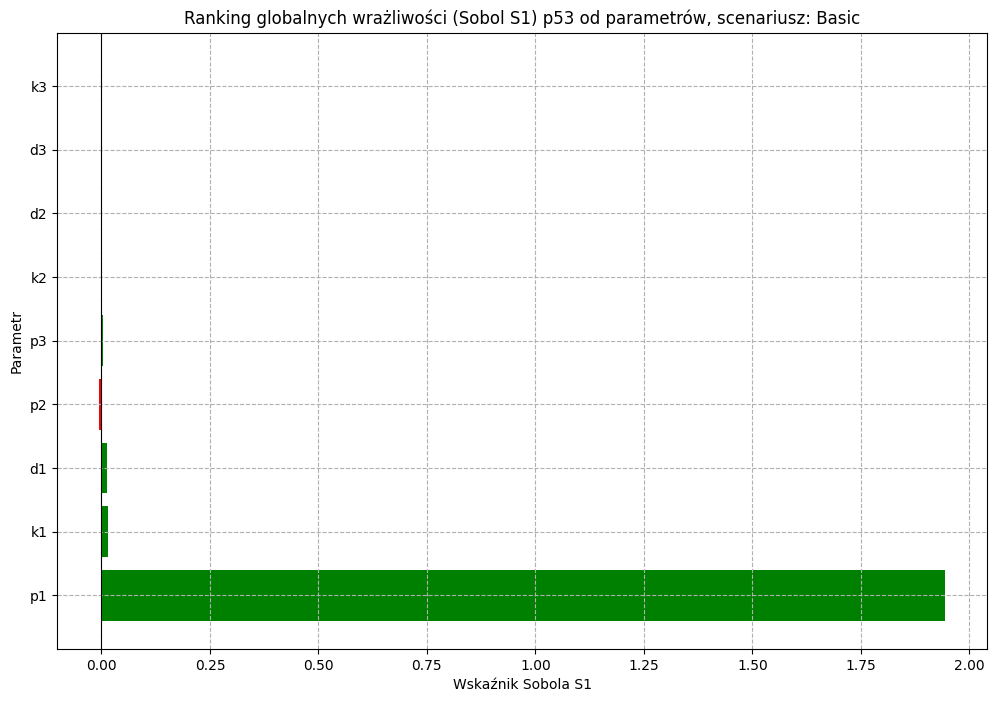

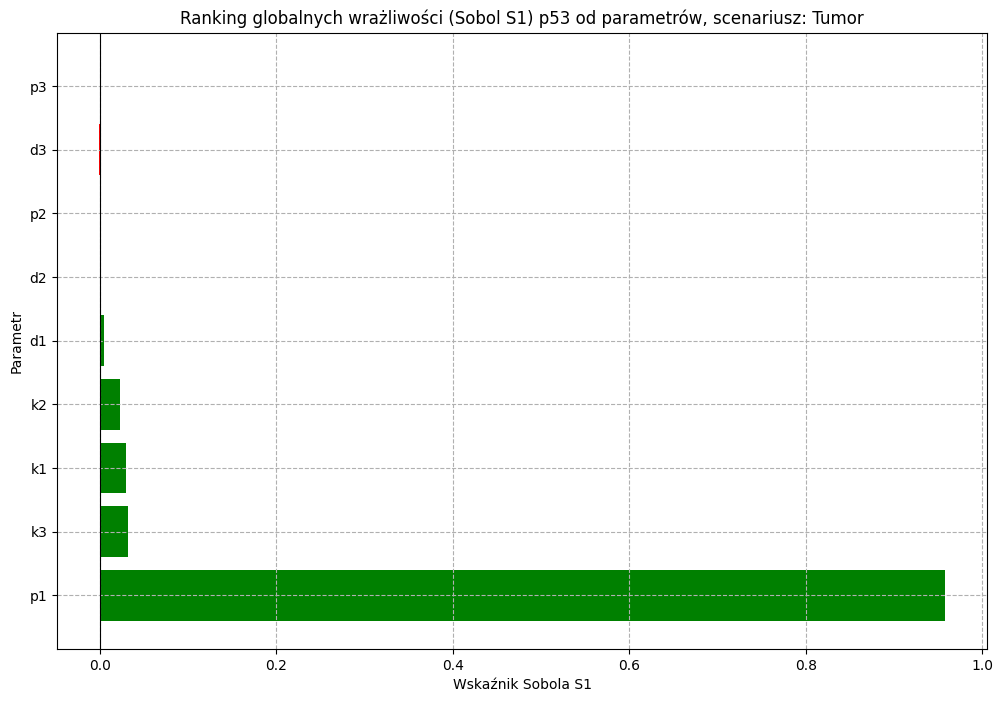

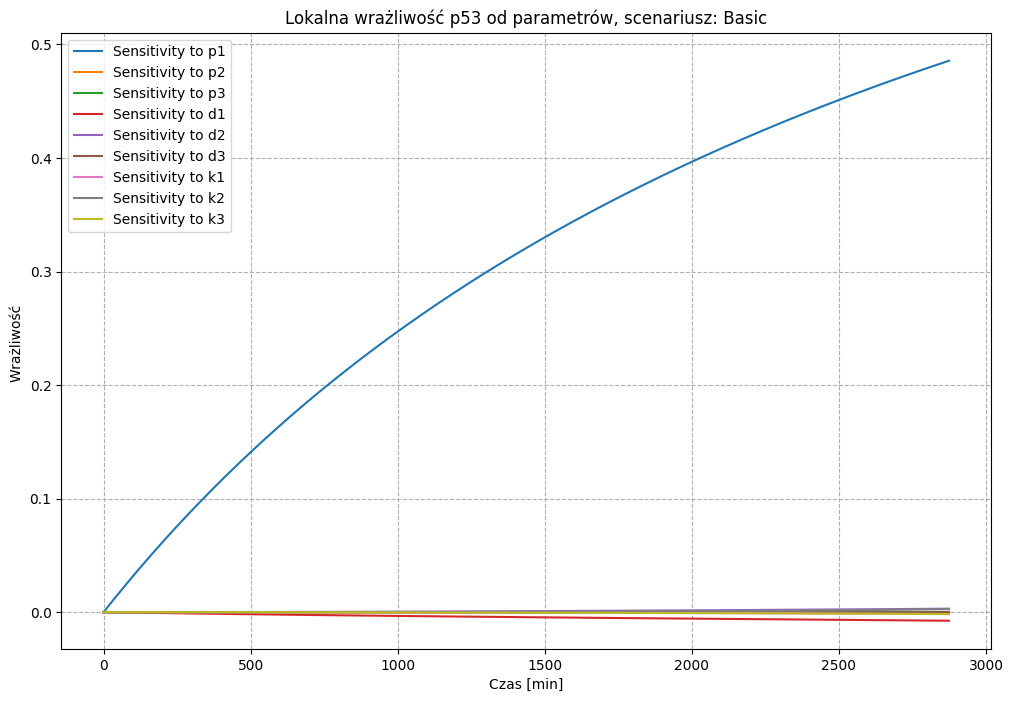

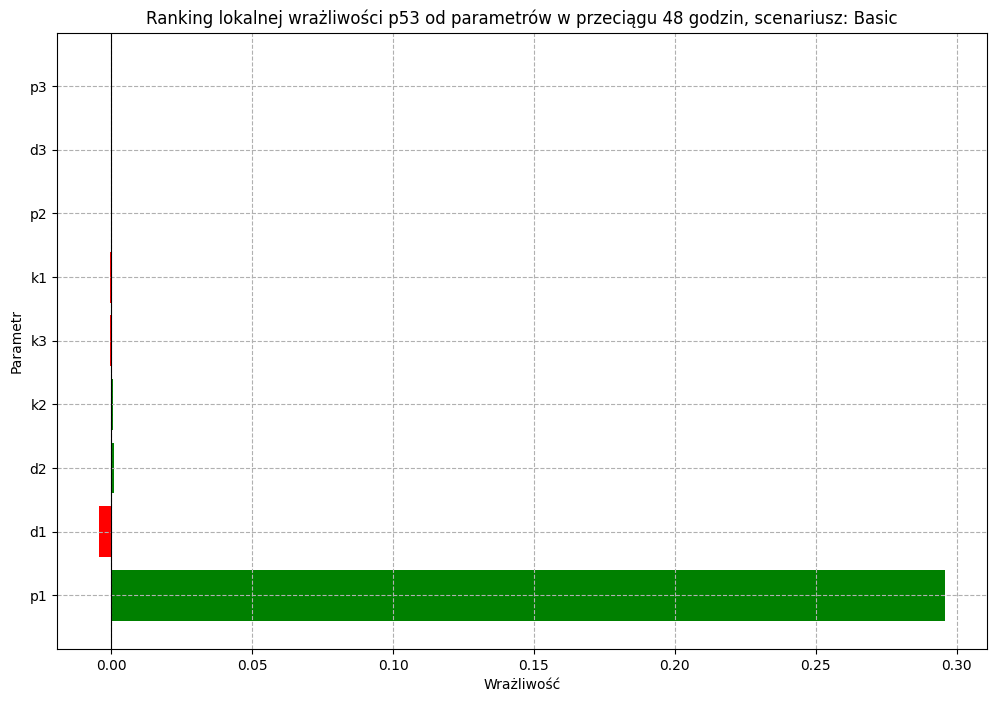

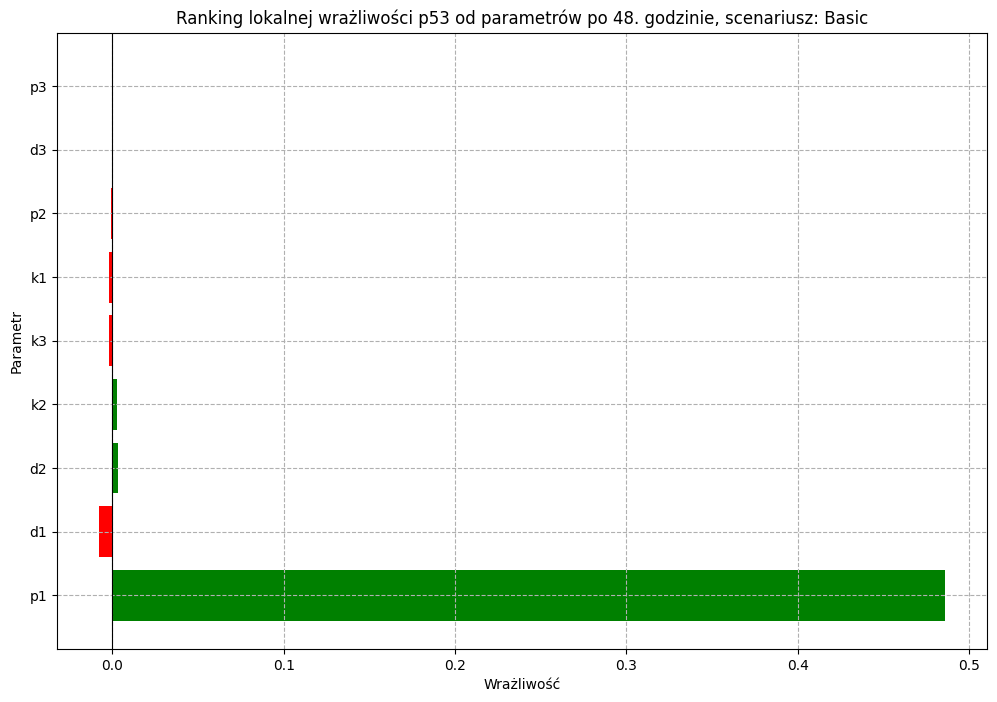

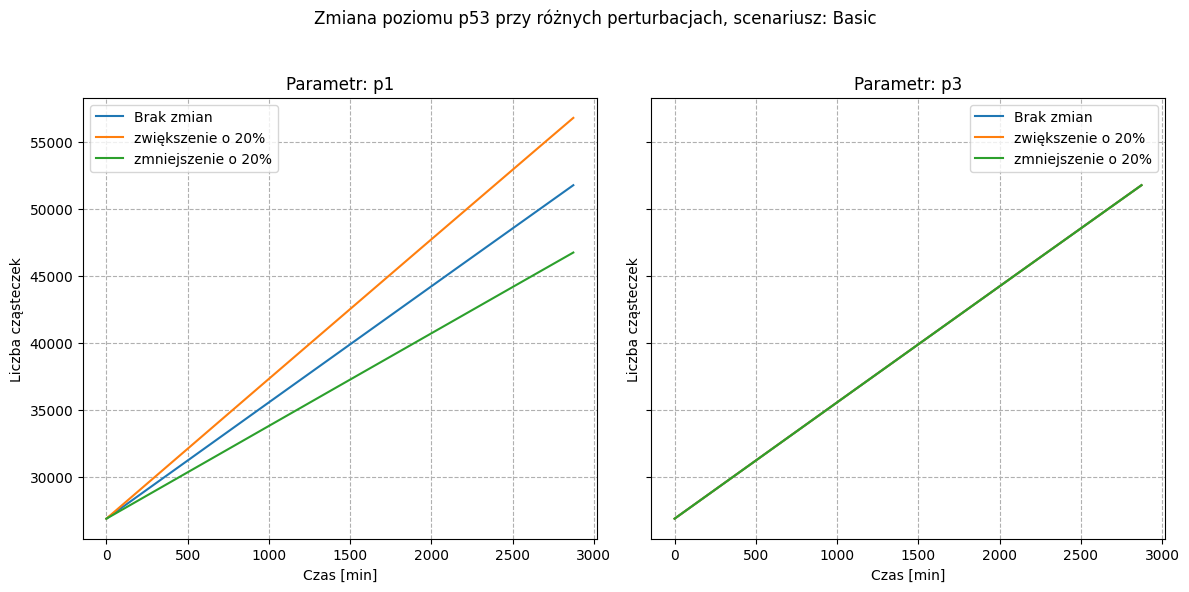

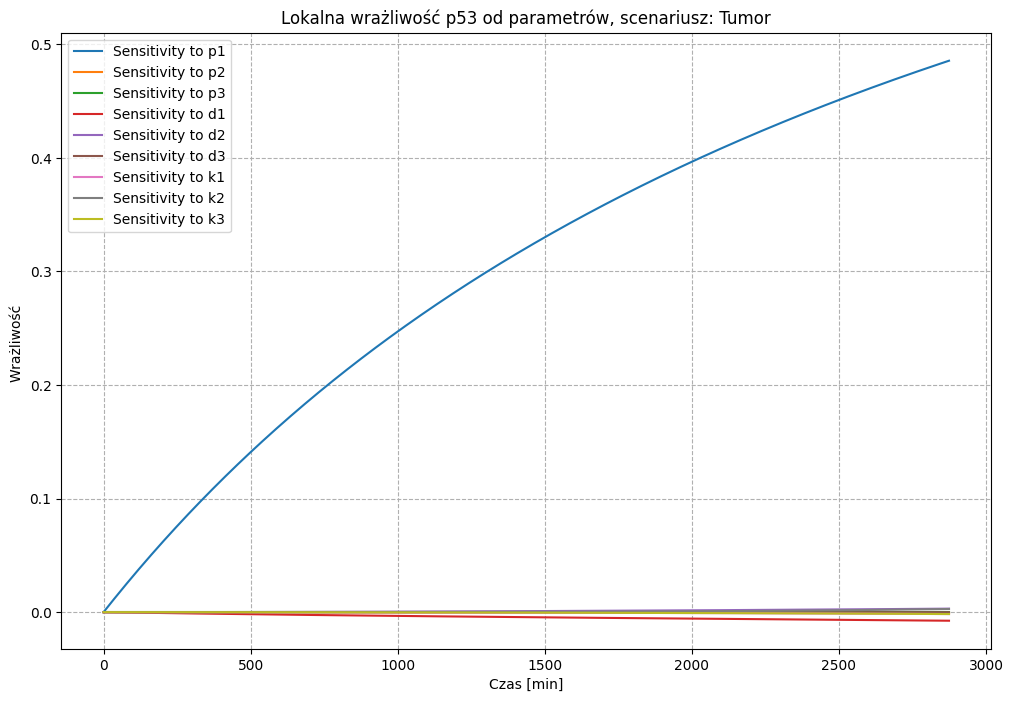

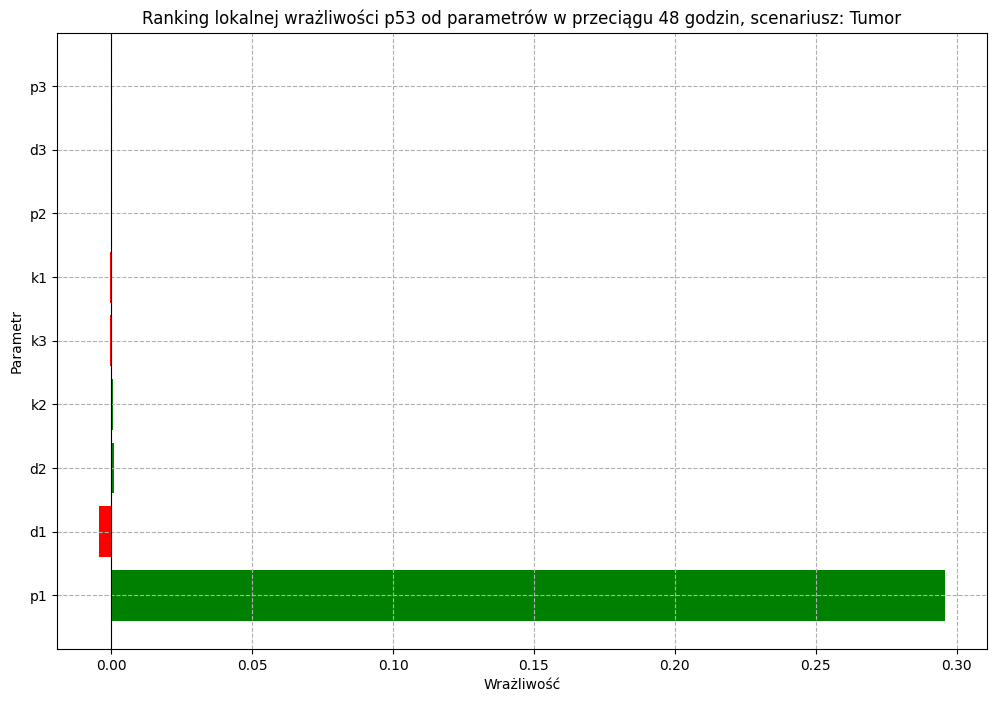

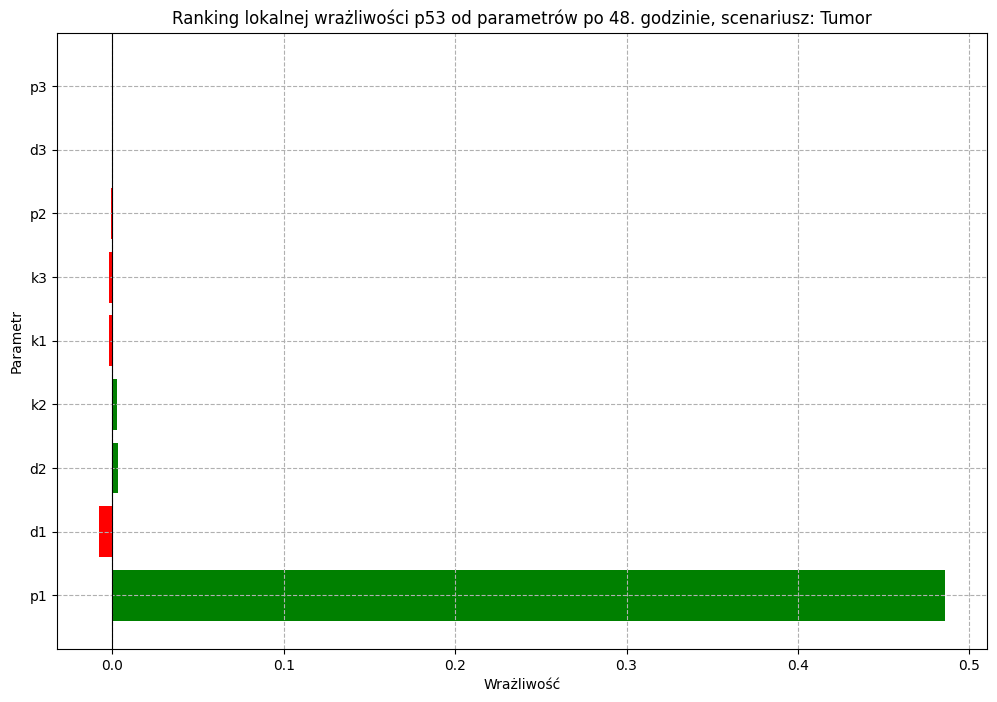

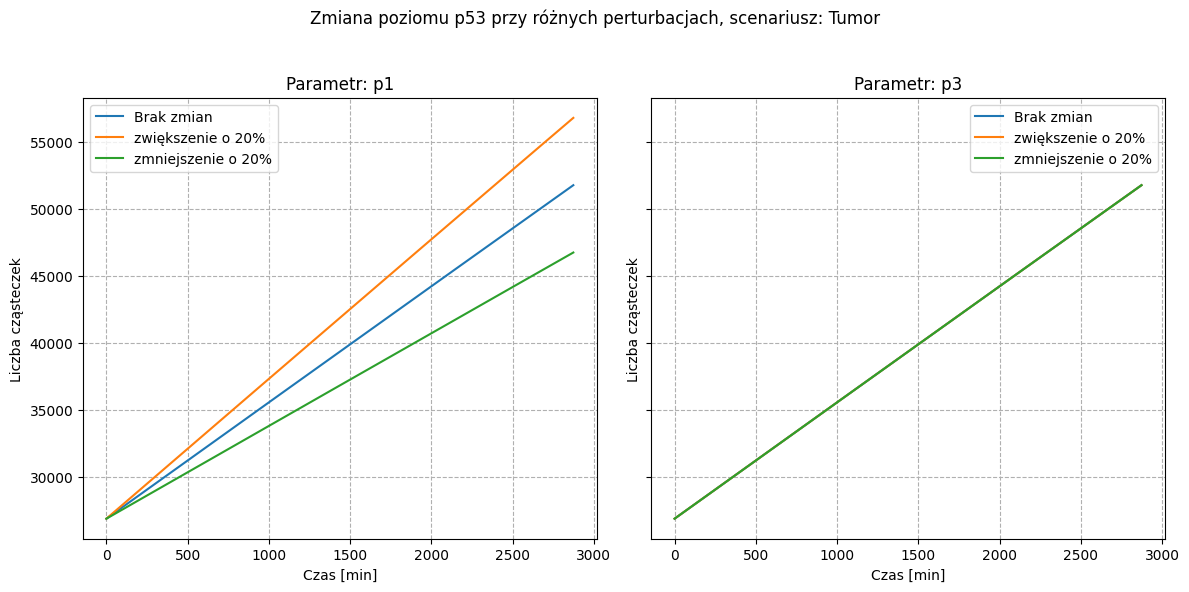

9


In [ ]:
def main():
    x = []

    param_names = list(params.keys())
    bounds = [[params[k]*0.8, params[k]*1.2] for k in param_names]

    for name, scenario in conditions.items():
        S1 = global_sensitivity(bounds, param_names, proteins, scenario, N=128)
        # Tworzymy ranking na podstawie wartości bezwzględnych S1
        ranking_global = sorted(zip(param_names, S1), key=lambda x: abs(x[1]), reverse=True)
        ranking_keys = [k for k, v in ranking_global]
        ranking_values = [v for k, v in ranking_global]

        # Wykres słupkowy S1
        plt.figure(figsize=(12, 8))
        plt.barh(ranking_keys, ranking_values, color=['green' if v >= 0 else 'red' for v in ranking_values])
        plt.axvline(0, color='black', linewidth=0.8)
        plt.title(f'Ranking globalnych wrażliwości (Sobol S1) p53 od parametrów, scenariusz: {name}')
        plt.xlabel("Wskaźnik Sobola S1")
        plt.ylabel("Parametr")
        plt.grid(True, which="both", ls="--")
        plt.show()
    def ranking(sensitivities):
        r1 = {k: np.mean(v)  for k, v in sensitivities.items()}
        ranked1 = sorted(r1.items(), key=lambda item: np.abs(item[1]), reverse=True)
        r2 = {k: v[-1] for k, v in sensitivities.items()}
        ranked2 = sorted(r2.items(), key=lambda item: np.abs(item[1]), reverse=True)
        return ranked1, ranked2
    for name, scenario in conditions.items(): 
        t, s, p53_nom = local_sensitivity(params, proteins, scenario)
        ranking1, ranking2 = ranking(s)
        ranking1_keys = [k for k, v in ranking1]
        ranking1_values = [v for k, v in ranking1]
        x.append(ranking1_values)
        ranking2_keys = [k for k, v in ranking2]
        ranking2_values = [v for k, v in ranking2]

        plt.figure(figsize=(12, 8))
        for key in s:
            plt.plot(t, s[key], label=f'Sensitivity to {key}')
        plt.title(f'Lokalna wrażliwość p53 od parametrów, scenariusz: {name}')
        plt.xlabel("Czas [min]")
        plt.ylabel("Wrażliwość ")
        # plt.yscale("log")
        plt.legend()
        plt.grid(True, which="both", ls="--")
        plt.show()        

        plt.figure(figsize=(12, 8))
        plt.barh(ranking1_keys, ranking1_values, color=['green' if v >= 0 else 'red' for v in ranking1_values])
        plt.axvline(0, color='black', linewidth=0.8)
        plt.title(f'Ranking lokalnej wrażliwości p53 od parametrów w przeciągu 48 godzin, scenariusz: {name}')
        plt.xlabel("Wrażliwość")
        plt.ylabel("Parametr")
        plt.grid(True, which="both", ls="--")
        plt.show()

        plt.figure(figsize=(12, 8))
        plt.barh(ranking2_keys, ranking2_values, color=['green' if v >= 0 else 'red' for v in ranking2_values])
        plt.axvline(0, color='black', linewidth=0.8)
        plt.title(f'Ranking lokalnej wrażliwości p53 od parametrów po 48. godzinie, scenariusz: {name}')
        plt.xlabel("Wrażliwość")
        plt.ylabel("Parametr")
        plt.grid(True, which="both", ls="--")
        plt.show()

        change = {
            ranking1[0][0]: [1.2, 0.8],
            ranking1[-1][0]: [1.2, 0.8]
        }
        n_facets = len(change)
        fig, axes = plt.subplots(1, n_facets, figsize=(6 * n_facets, 6), sharey=True)
        for ax, (p, c_values) in zip(axes, change.items()):
            t, p53_perturbed = RK4(params, proteins, scenario, iterations, h)
            ax.plot(t, p53_perturbed[0], label=f'Brak zmian')
            for c in c_values:
                params_perturbed = params.copy()
                params_perturbed[p] = params_perturbed[p] * c
                t, p53_perturbed = RK4(params_perturbed, proteins, scenario, iterations, h)
                ax.plot(t, p53_perturbed[0], label=f'{"zwiększenie" if c > 1 else "zmniejszenie"} o 20%')
            ax.set_title(f'Parametr: {p}')
            ax.set_xlabel("Czas [min]")
            ax.set_ylabel("Liczba cząsteczek")
            ax.legend()
            ax.grid(True, which="both", ls="--")
        plt.suptitle(f'Zmiana poziomu p53 przy różnych perturbacjach, scenariusz: {name}')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()    
    
    print(sum(x != y for x, y in zip(x[0], x[1])))

main()

Dla porówniania pozwolę sobie skorzystać z rozwiązań gotowych oferowanych przez pakiet SALib (niby nie mówił Profesor, że nie można korzystać z takich, ale uznaliśmy że nie wypada, więc to tylko kontrolnie):

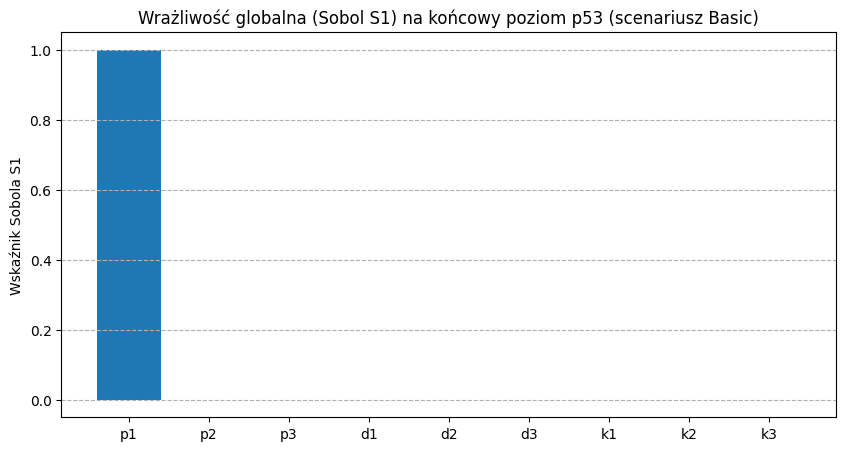

In [26]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from SALib.sample import sobol as sobolsample
from SALib.analyze import sobol

# Definicja problemu dla SALib
problem = {
    'num_vars': len(param_names),
    'names': param_names,
    'bounds': bounds
}

# Generowanie próbek
param_values = sobolsample.sample(problem, 256, calc_second_order=False)

def run_model_sobol(params_row):
    p = dict(zip(param_names, params_row))
    # Używamy tych samych wartości value_siRNA, value_PTEN_off, value_no_DNA_damage co w modelu
    t, y = RK4(p, proteins, conditions["Basic"], iterations, h)
    return y[0][-1]  # końcowy poziom p53

# Symulacja dla wszystkich próbek
Y = np.array([run_model_sobol(row) for row in param_values])

# Analiza Sobola
Si = sobol.analyze(problem, Y, calc_second_order=False)

# Wyniki S1
plt.figure(figsize=(10,5))
plt.bar(param_names, Si['S1'])
plt.ylabel("Wskaźnik Sobola S1")
plt.title("Wrażliwość globalna (Sobol S1) na końcowy poziom p53 (scenariusz Basic)")
plt.grid(True, axis='y', ls='--')
plt.show()

# Wyświetlenie wartości S1
# for name, s1 in zip(param_names, Si['S1']):
#     print(f"{name}: S1 = {s1:.3f}")


## 8. Wnioski

Podstawowa analiza globalnej wrażliwości w mojej implementacji daje bardzo podobne wyniki co ta z pakietu SALib:

| Parametr | S1 (moja implementacja) | S1 (SALib) |
|----------|:----------------------:|:----------:|
| p1       | 0.915                  | 0.998      |
| p2       | 0.001                  | -0.000     |
| p3       | -0.000                 | 0.000      |
| d1       | 0.011                  | 0.001      |
| d2       | -0.004                 | -0.000     |
| d3       | -0.000                 | 0.000      |
| k1       | -0.011                 | 0.000      |
| k2       | 0.001                  | 0.000      |
| k3       | -0.005                 | 0.000      |

---